In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

from models import CLASSIFIERS

In [2]:
try:
    from utils import DATA_PATH
except ImportError:  # notebook being ran in child dir
    import sys

    sys.path.insert(0, "..")  # add parent to path
    from utils import DATA_PATH

In [3]:
from sklearn.utils.fixes import loguniform
rv = loguniform(1e0, 1e3)

rv.rvs(random_state=42, size=1000)

array([ 13.29291894, 711.44760093, 157.02970884,  62.51373575,
         2.93802794,   2.93753846,   1.49365686, 396.76050771,
        63.58358857, 133.11216081,   1.15279871, 812.32450856,
       314.28808908,   4.33528179,   3.51135631,   3.54987883,
         8.17949948,  37.52055855,  19.76218934,   7.47631206,
        68.47920096,   2.62108788,   7.52374288,  12.5627735 ,
        23.34586408, 226.73986524,   3.97211073,  34.89018845,
        59.8747491 ,   1.37832375,  66.47135865,   3.24767357,
         1.56730955, 702.51663392, 788.671413  , 266.19018885,
         8.2005184 ,   1.96343416, 112.90133559,  20.91498133,
         2.32335035,  30.58656667,   1.26813522, 534.51661106,
         5.975028  ,  97.17775305,   8.61257919,  36.32486957,
        43.66473593,   3.58561261, 810.50161264, 211.54290797,
       658.41061601, 483.59527765,  62.18704728, 582.9384543 ,
         1.84279704,   3.87211803,   1.36672729,   9.46217536,
        14.65655389,   6.51699061, 306.34622106,  11.75

In [4]:
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2041 entries, 0 to 2040
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     2041 non-null   int64         
 1   Date                           2041 non-null   datetime64[ns]
 2   Site                           2041 non-null   object        
 3   Staff Reported Positive Tests  2041 non-null   int64         
 4   # of Currently Positive Staff  2041 non-null   int64         
 5    Staff Deaths                  2041 non-null   int64         
 6   Staff Recovered                2041 non-null   int64         
 7   Housing type                   2041 non-null   object        
 8   Isolation Inmates              2041 non-null   int64         
 9   Positive Inmates               2041 non-null   int64         
 10  Confirmed Inmate Deaths        2041 non-null   int64         
 11  Pending Results  

In [6]:
df.columns

Index(['Unnamed: 0', 'Date', 'Site', 'Staff Reported Positive Tests',
       '# of Currently Positive Staff', ' Staff Deaths', 'Staff Recovered',
       'Housing type', 'Isolation Inmates', 'Positive Inmates',
       'Confirmed Inmate Deaths', 'Pending Results', 'Recovered Inmates',
       'Daily Recovered', 'N1', 'N2', 'B.1.1.7 (Alpha)', 'B.1.351 (Beta)',
       'P.1 (Gamma)', 'B.1.617 (Delta)', 'B.1.427/B.1.429 (Epsilon)',
       'N679K/Q954H (Omicron)', 'Presumptive Cases',
       'Average Presumptive Cases', 'Y', 'X', 'housing_factor', 'site_factor'],
      dtype='object')

In [7]:
# Create color maps
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

In [19]:
def set_x_cols(df, x_cols, y_col="housing_factor", groups=("Site")):
    df = df.dropna(subset=[*x_cols, y_col])
    X = df[x_cols]
    y = df[y_col]
    X = StandardScaler().fit_transform(X)
    groups = df[groups]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, stratify=groups)

    x0_min, x0_max = X[:, 0].min(), X[:, 0].max()
    if X.shape[1] == 2:
        x1_min, x1_max = X[:, 1].min(), X[:, 1].max()
    else: x1_min, x1_max = x0_min, x0_max
    h = abs(min(x0_min, x0_max, x1_min, x1_max) - max(x0_min, x0_max, x1_min, x1_max)) / 1000
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
    
    return X_train, X_test, X, y_train, y_test, y, xx0, xx1

In [64]:
def score_model(X_train, X_test, X, y_train, y_test, model):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(score)
    return score

def plot_clasifier(X, y, xx0, xx1, x_cols, score, model, model_type):

    fig = plt.figure()

    # Put the result into a color plot
    Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
    Z = Z.reshape(xx0.shape)
    plt.pcolormesh(xx0, xx1, Z, cmap=cmap_light, alpha=0.8, shading="auto")

    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)

    plt.xlabel(x_cols[0])
    plt.ylabel(x_cols[1])
    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    plt.title(f"{model_type}")
    plt.text(
        0.7,
        0.1,
        "Test Classification\nAccuracy: {:.2f}".format(score),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )
    fig.savefig(DATA_PATH.parent / f"figures/classifier-{model_type}.png")
    plt.show()
    

def score_and_plot_classifiers(X_train, X_test, X, y_train, y_test, y, xx0, xx1, x_cols):
    for d in CLASSIFIERS.values():
        model = d["model"]
        model_type = d["label"]
        print(f"Model type: {model_type}")
        score = score_model(X_train, X_test, X, y_train, y_test, model)
        plot_clasifier(X, y, xx0, xx1, x_cols, score, model, model_type)

In [54]:
x_cols = ["Recovered Inmates"]
X_train, X_test, X, y_train, y_test, y, xx0, xx1 = set_x_cols(df, x_cols)
for d in CLASSIFIERS.values():
    model = d["model"]
    score = score_model(X_train, X_test, X, y_train, y_test, model)

0.6673189823874756
0.4344422700587084
0.5420743639921722
0.6810176125244618
0.6575342465753424
0.4344422700587084


In [55]:
x_cols = [ "# of Currently Positive Staff"]
X_train, X_test, X, y_train, y_test, y, xx0, xx1 = set_x_cols(df, x_cols)
for d in CLASSIFIERS.values():
    model = d["model"]
    score = score_model(X_train, X_test, X, y_train, y_test, model)

0.4207436399217221
0.42857142857142855
0.42857142857142855
0.43052837573385516
0.436399217221135
0.37181996086105673


In [56]:
x_cols = ["Confirmed Inmate Deaths"]
X_train, X_test, X, y_train, y_test, y, xx0, xx1 = set_x_cols(df, x_cols)
for d in CLASSIFIERS.values():
    model = d["model"]
    score = score_model(X_train, X_test, X, y_train, y_test, model)

0.684931506849315
0.5283757338551859
0.6223091976516634
0.6810176125244618
0.6731898238747553
0.4637964774951076


In [57]:
x_cols = ["Confirmed Inmate Deaths", "Recovered Inmates"]
X_train, X_test, X, y_train, y_test, y, xx0, xx1 = set_x_cols(df.loc[(df["Recovered Inmates"] >0) & (df["Confirmed Inmate Deaths"] >0)], x_cols)
for d in CLASSIFIERS.values():
    model = d["model"]
    score = score_model(X_train, X_test, X, y_train, y_test, model)

0.9680851063829787
0.5602836879432624
0.7872340425531915
0.9574468085106383
0.9326241134751773
0.4219858156028369


In [58]:
x_cols = [ "Recovered Inmates"]
X_train, X_test, X, y_train, y_test, y, xx0, xx1 = set_x_cols(df, x_cols)
for d in CLASSIFIERS.values():
    model = d["model"]
    score = score_model(X_train, X_test, X, y_train, y_test, model)

0.6673189823874756
0.4344422700587084
0.5420743639921722
0.6810176125244618
0.6634050880626223
0.4344422700587084


Model type: KK Nearest Neighbor
0.8825831702544031


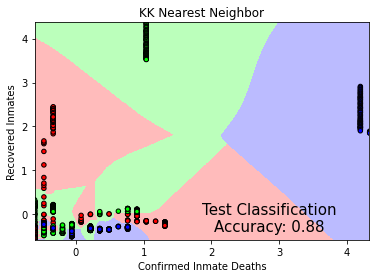

Model type: Linear SVC
0.5401174168297456


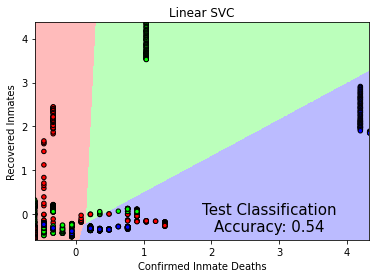

Model type: RBF SVC
0.7788649706457925


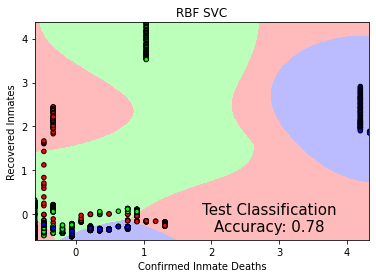

Model type: Decision Tree
0.8845401174168297


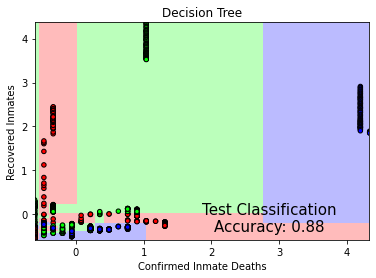

Model type: Random Forest
0.8434442270058709


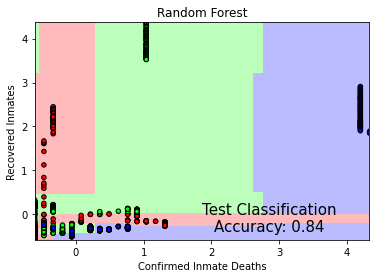

Model type: Gaussian Naive Bayes
0.41291585127201563


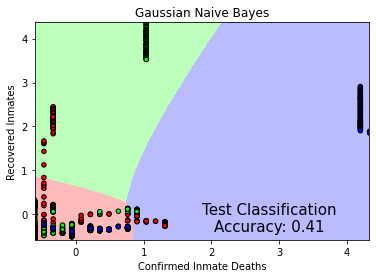

In [65]:
x_cols = ["Confirmed Inmate Deaths", "Recovered Inmates"]
X_train, X_test, X, y_train, y_test, y, xx0, xx1 = set_x_cols(df, x_cols)
score_and_plot_classifiers(X_train, X_test, X, y_train, y_test, y, xx0, xx1, x_cols)